In [1]:
%load_ext autoreload
%autoreload 2

import lzma
import pickle
import hashlib
import pandas as pd
import numpy as np
import requests as r
import seaborn as sns
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from json import load, dump, loads, dumps
from joblib import hash
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import KMeans
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MultiLabelBinarizer
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

warnings.simplefilter('ignore')
mpl.style.use('ggplot')

## Source Data

IF source data is missing run Elasticsearch query to extract data and then save it in JSON format to `data` directory

In [2]:
# news_json = r.get('http://test.saidsef.co.uk:9200/slashnews/scraped/_search?sort=date:desc&size=6000').json()
# with lzma.open('./data/news.json.xz', 'wt', encoding='utf-8') as fh:
#   fh.write(dumps(news_json['hits']['hits']))

In [3]:
# df = pd.json_normalize(news_json['hits']['hits'])
# df = df[['_source.body', '_source.date', '_source.subject', '_source.language', '_source.categories']]
# df.columns = ['body', 'pubdate', 'subject', 'language', 'categories']
# df = df.loc[(df['categories'] != 'News') & 
#             (df['categories'] != 'Uncategorized') &
#             (df['language'] == 'English')]

In [4]:
# df.to_csv('./data/news.json.xz', mode='wt', encoding='utf-8', compression='xz', index=False)

In [5]:
# b = loads(lzma.open('./data/news.json.xz', 'rt', encoding='utf-8').read())
# df = pd.json_normalize(b)
df = pd.read_csv('./data/news.json.xz')

## Common issues that we generally face during the data preparation phase:
 - Format and structure normalization
 - Detect and fix missing values
 - Duplicates removal
 - Units normalization
 - Constraints validations
 - Anomaly detection and removal
 - Study of features importance/relevance
 - Dimentional reduction, feature selection & extraction

In [6]:
df.drop_duplicates(inplace=True)
df.head(1).T.style

,0
body,"The International Atomic Energy Agency (IAEA) said today that Japan continues to comply with international safety standards in its discharge of ALPS treated water from the Fukushima Daiichi Nuclear Power Station (FDNPS), following the latest review mission by the Task Force set up to assess the safety of the process."
pubdate,2025-05-30T07:45:00.000Z
subject,"Japan's ALPS Treated Water Release Continues to Comply with International Safety Standards, IAEA Task Force Mission Confirms"
language,English
categories,Press Release


In [7]:
df['categories'] = df['categories'].str.replace(r'[^a-zA-Z_, ]+', '').replace(', ', '')
df['categories'] = df['categories'].str.replace(r'^, ', '')
df = df[~df.eq('').all(1)]
df = df[df.groupby('categories')['categories'].transform('count') >= 10]

In [8]:
df.groupby(['categories']).agg({'count'}).drop_duplicates()

,body,pubdate,subject,language
,count,count,count,count
categories,,,,
"Afghanistan, Asia & Americas, Europe & Russia",11,11,11,11
"Africa, Algeria, Europe & Russia",26,26,26,26
"Africa, Algeria, News",13,13,13,13
"Africa, Article, Asia & Americas",27,27,27,27
"Africa, Article, Egypt",28,28,28,28
"Africa, Asia & Americas, Egypt",36,36,36,36
"Africa, EU, Europe & Russia",12,12,12,12
"Africa, Egypt, Europe & Russia",39,39,39,39


In [9]:
df['cat_id']       = df['categories'].factorize()[0]
df['lang_id']      = df['language'].factorize()[0]
df['char_count']   = df['body'].apply(len)
df['word_count']   = df['body'].apply(lambda x: len(x.split()))
df['word_density'] = df['char_count'] / (df['word_count']+1)


In [10]:
df = df.dropna()

In [11]:
print(df.shape)

(3040, 10)


In [12]:
df.sem(numeric_only=True)

cat_id           0.416973
lang_id          0.000000
char_count      20.377296
word_count       3.121764
word_density     0.007818
dtype: float64

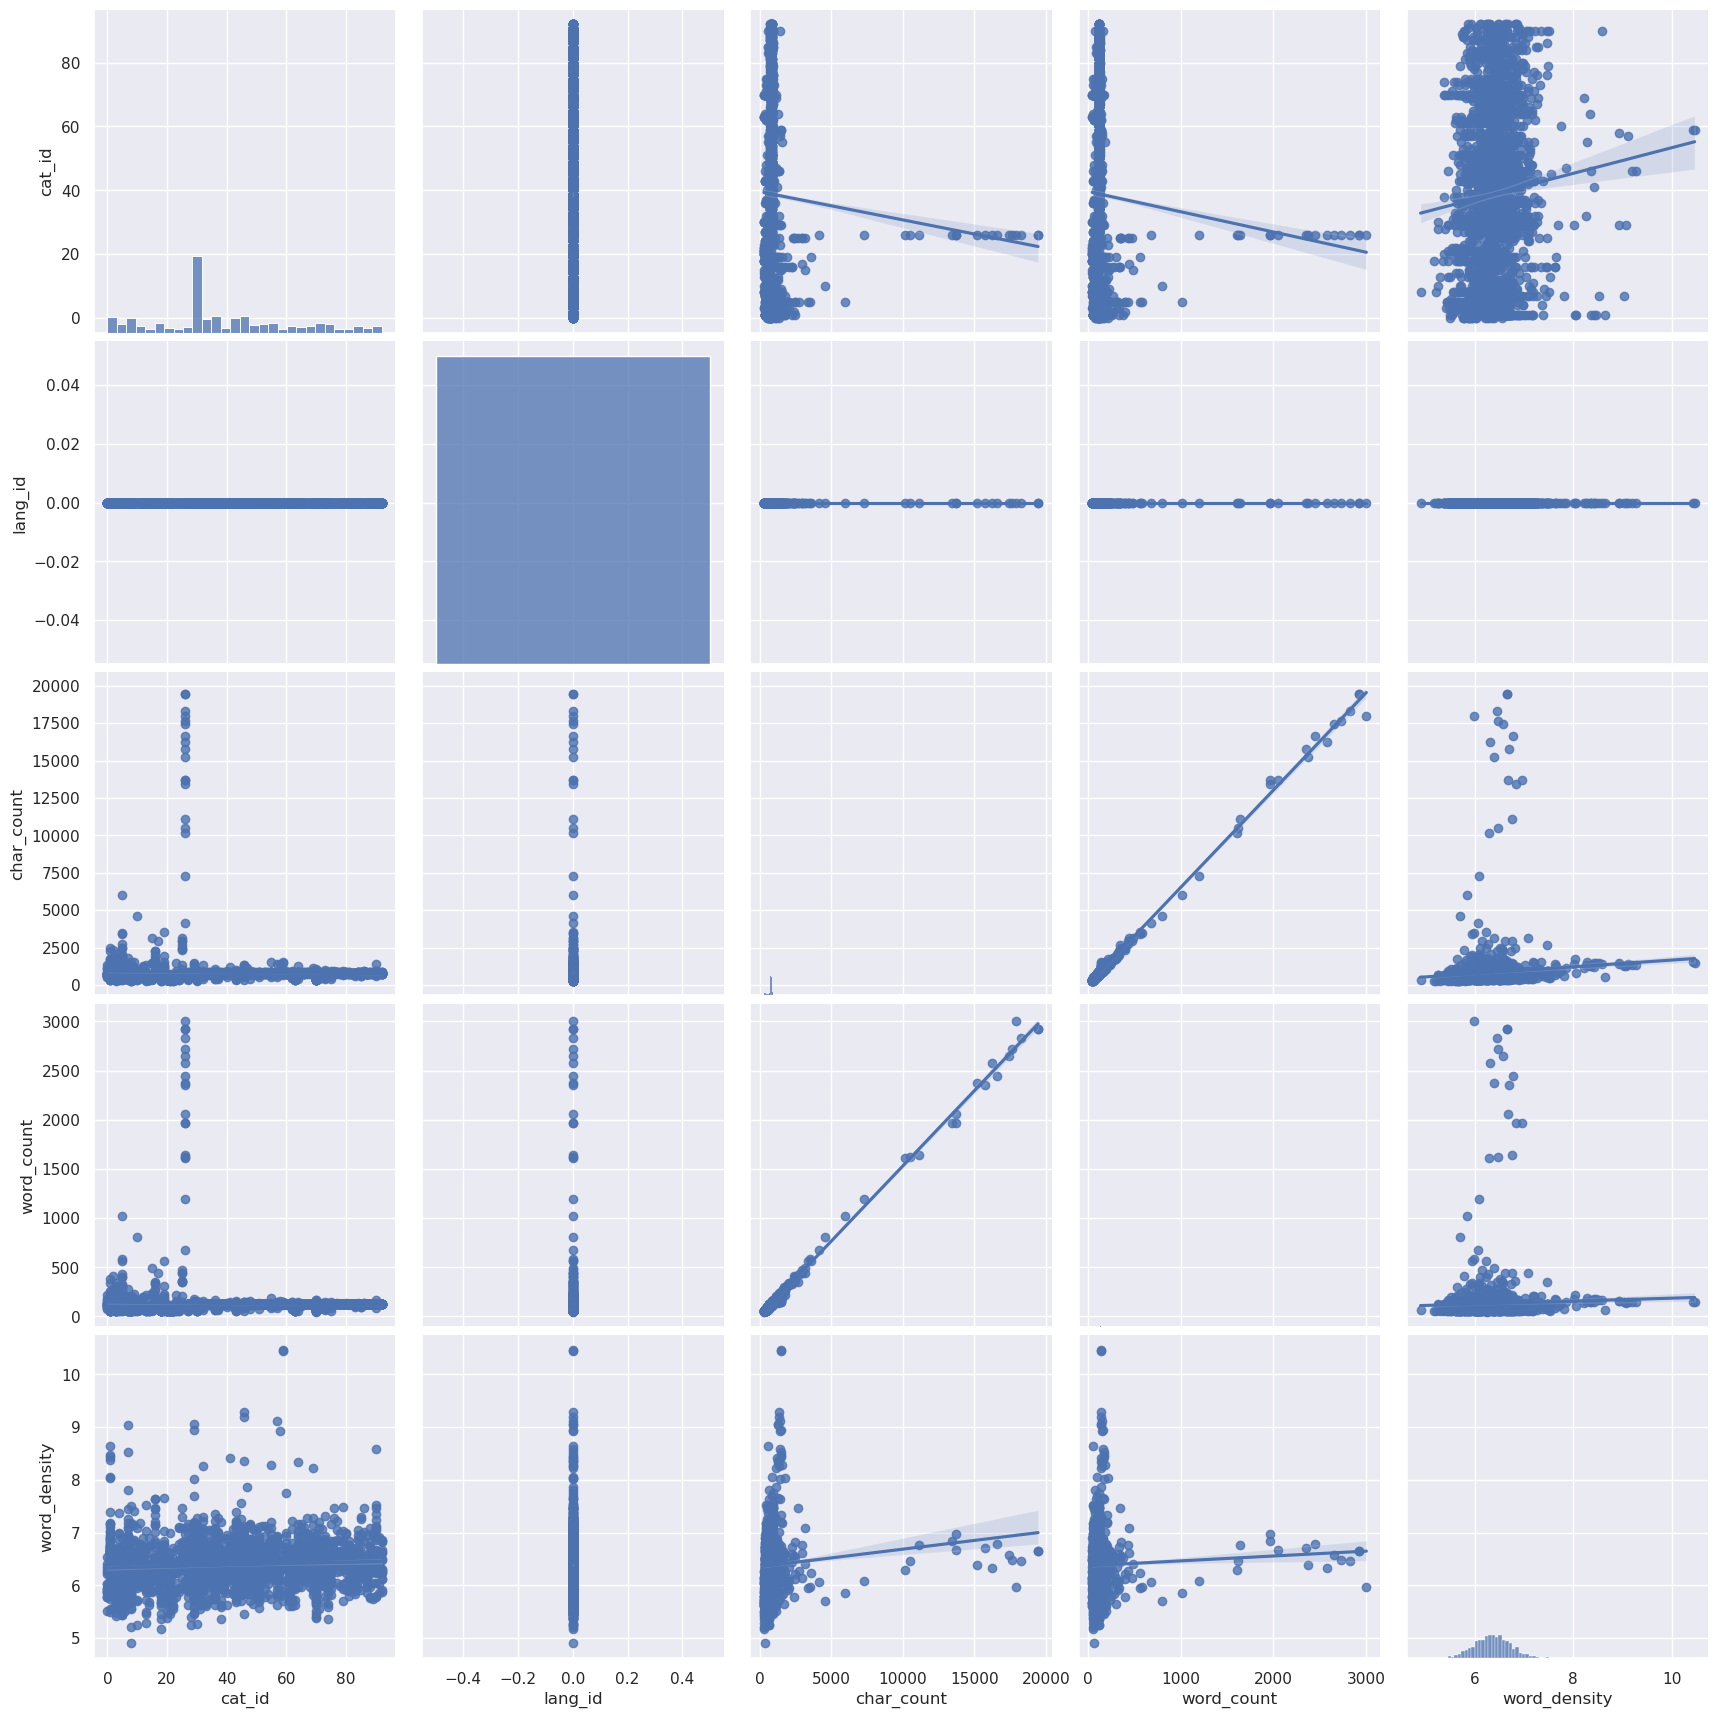

In [13]:
sns.set()
sns.pairplot(df, height=3.5, kind="reg", palette="husl", diag_kind="auto")

In [15]:
xtrain, xtest, ytrain, ytest = train_test_split(df['body'], df['categories'], test_size=0.3, random_state=42, shuffle=True, stratify=df['categories'])

In [16]:
print(f"X Train: {xtrain.shape}, Y Train: {ytrain.shape}")
print(f"X Test: {xtest.shape}, Y Test: {ytest.shape}")

X Train: (2128,), Y Train: (2128,)
X Test: (912,), Y Test: (912,)


In [17]:
estimators = [
      # ('AdaBoostClassifier', AdaBoostClassifier(n_estimators=100)), # 0.02
      ('LogisticRegression', SelfTrainingClassifier(LogisticRegression(fit_intercept=True, max_iter=3000, C=50.0, class_weight='balanced'), threshold=0.9, max_iter=10)),
      # ('SGDClassifier', SelfTrainingClassifier(SGDClassifier(fit_intercept=False, loss='modified_huber', max_iter=2000))), # 10%
      ('RandomForestClassifier', SelfTrainingClassifier(RandomForestClassifier(min_samples_leaf=25, min_samples_split=60, max_depth=30, n_estimators=400, class_weight='balanced'), threshold=0.75)),
      ('MLPClassifier', SelfTrainingClassifier(MLPClassifier(max_iter=1000, hidden_layer_sizes=(400, 200, 100), alpha=0.003, early_stopping=True, validation_fraction=0.2, learning_rate='adaptive'), threshold=0.9)),
      ('DecisionTreeClassifier', SelfTrainingClassifier(DecisionTreeClassifier(min_samples_leaf=60, min_samples_split=120, max_depth=25, class_weight='balanced'), threshold=0.8)),
      # ('GradientBoostingClassifier', GradientBoostingClassifier(min_samples_leaf=0.01)), # takes too long > 20 min
    ]

In [30]:
vote = Pipeline([
      ('vect', TfidfVectorizer(sublinear_tf=True, encoding='latin-1', analyzer='word', lowercase=True, ngram_range=(1, 3), stop_words='english', min_df=3, max_df=0.85, max_features=12000)),
      # ('tfidf', TfidfTransformer(sublinear_tf=True, use_idf=True, smooth_idf=True)), # removed as it is already included in TfidfVectorizer
      ('scaler', MaxAbsScaler(copy=False)),
      # ('scaler', StandardScaler(copy=False,with_mean=False, with_std=True)),
      ('feature_union', FeatureUnion([
        ('select_best', SelectKBest(score_func=f_classif, k=500)), # reduce to 500 features
        ('kmeans', KMeans(n_clusters=10, random_state=42, verbose=10)),
      ])),
      ('clf', VotingClassifier(estimators=estimators, voting='soft', verbose=True))])
vote.fit(xtrain, ytrain)
prediction = vote.predict(xtest)
score      = vote.score(xtest, prediction)

Initialization complete
Iteration 0, inertia 100000.12863780712.
Iteration 1, inertia 62748.90618237871.
Iteration 2, inertia 61956.29724329497.
Iteration 3, inertia 61755.163424094724.
Iteration 4, inertia 61435.99657575978.
Iteration 5, inertia 61428.47787712935.
Iteration 6, inertia 61414.00058840847.
Iteration 7, inertia 61387.01608097556.
Iteration 8, inertia 61360.40395806811.
Iteration 9, inertia 61340.15273149106.
Iteration 10, inertia 61330.995236283896.
Iteration 11, inertia 61324.847138805664.
Iteration 12, inertia 61322.210910771646.
Iteration 13, inertia 61321.20819983899.
Converged at iteration 13: strict convergence.
[Voting] ....... (1 of 4) Processing LogisticRegression, total=  41.3s
[Voting] ... (2 of 4) Processing RandomForestClassifier, total=   1.0s
[Voting] ............ (3 of 4) Processing MLPClassifier, total=  11.7s
[Voting] ... (4 of 4) Processing DecisionTreeClassifier, total=   0.1s


In [31]:
print(f'{accuracy_score(ytest, prediction) * 100:.3f}%')

44.189%


In [32]:
print(classification_report(ytest, prediction, digits=3))

                                                               precision    recall  f1-score   support

                Afghanistan, Asia & Americas, Europe & Russia      1.000     0.667     0.800         3
                             Africa, Algeria, Europe & Russia      0.462     0.750     0.571         8
                                        Africa, Algeria, News      0.000     0.000     0.000         4
                             Africa, Article, Asia & Americas      0.000     0.000     0.000         8
                                       Africa, Article, Egypt      0.333     0.250     0.286         8
                               Africa, Asia & Americas, Egypt      0.800     0.364     0.500        11
                                  Africa, EU, Europe & Russia      0.000     0.000     0.000         4
                               Africa, Egypt, Europe & Russia      0.600     0.500     0.545        12
                                        Africa, Egypt, Israel      0.692

In [33]:
s = '''

‘Guys, you’ve got to hear this,” I said. I was sitting in front of my computer one day in July 2012, with one eye on a screen of share prices and the other on a live stream of the House of Commons Treasury select committee hearings. As the Barclays share price took a graceful swan dive, I pulled my headphones out of the socket and turned up the volume so everyone could hear. My colleagues left their terminals and came around to watch BBC Parliament with me.

It didn’t take long to realise what was happening. “Bob’s getting murdered,” someone said.

Bob Diamond, the swashbuckling chief executive of Barclays, had been called before the committee to explain exactly what his bank had been playing at in regards to the Libor rate-fixing scandal. The day before his appearance, he had made things very much worse by seeming to accuse the deputy governor of the Bank of England of ordering him to fiddle an important benchmark, then walking back the accusation as soon as it was challenged. He was trying to turn on his legendary charm in front of a committee of angry MPs, and it wasn’t working. On our trading floor, in Mayfair, calls were coming in from all over the City. Investors needed to know what was happening and whether the damage was reparable.

A couple of weeks later, the damage was done. The money was gone, Diamond was out of a job and the market, as it always does, had moved on. We were left asking ourselves: How did we get it so wrong?

'''

In [34]:
vote.predict([s])[0].split(',')

['Opinion']

In [35]:
with lzma.open('./data/voting_classifier.pickle.xz', 'wb') as f:
  pickle.dump(vote, f, protocol=5)

In [43]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [234]:
# dt = DecisionTreeClassifier(min_samples_leaf=1)
# dt.fit(vote.named_steps['vect'].transform(xtrain), vote.predict(xtrain))

In [ ]:
def serialize_and_hash(data):
    serialized_data = pickle.dumps(data)
    data_hash = hashlib.sha256(serialized_data).hexdigest()
    return serialized_data, data_hash

def verify_integrity(serialized_data, stored_hash):
    calculated_hash = hashlib.sha256(serialized_data).hexdigest()
    return calculated_hash == stored_hash

# Example usage
data = df
serialized_data, data_hash = serialize_and_hash(data)

# When loading
# Load serialized_data and stored_hash
with lzma.open('./data/voting_classifier.pickle.xz', 'rb') as f:
    loaded_serialized_data = f.read()

# Load the stored hash
with lzma.open('./data/news.json.xz', 'rt') as f:
    stored_hash = f.read()

if verify_integrity(loaded_serialized_data, stored_hash):
    loaded_data = pickle.loads(loaded_serialized_data)
    print("Data integrity verified!")
else:
    print("Data integrity verification failed!")